In [1]:
import torch
from xopt import Xopt
import yaml

YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name: bayesian_exploration
    n_initial: 5
    optim:
        num_restarts: 1
    acq:
        proximal_lengthscales: [1.5, 1.5]

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [2]:
X = Xopt(config=yaml_output)
X


            Xopt
________________________________
Version: 0+untagged.1.g6498d4a
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: dump.yaml, max_evaluations: null}
generator:
  name: bayesian_exploration
  optim: {num_restarts: 1, raw_samples: 20, sequential: true, use_nearby_initial_points: true,
    max_travel_distances: null}
  acq:
    proximal_lengthscales: [1.5, 1.5]
    use_transformed_proximal_weights: true
    monte_carlo_samples: 128
  model:
    function: xopt.generators.bayesian.models.standard.create_standard_model
    kwargs: {use_conservative_prior_lengthscale: false, use_conservative_prior_mean: false,
      use_low_noise_prior: false}
  n_initial: 5
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LES

In [3]:
X.step()

for i in range(5):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4


In [4]:
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
1,1.701103,1.174959,dummy_constant,1.701103,1.174959,3.371257,1.898219,"[1, 2, 3]",0.000066,False
2,3.127722,2.909305,dummy_constant,3.127722,2.909305,17.162982,12.709676,"[1, 2, 3]",0.000013,False
3,1.022338,1.405980,dummy_constant,1.022338,1.405980,2.102490,1.093637,"[1, 2, 3]",0.000011,False
4,3.021522,1.289140,dummy_constant,3.021522,1.289140,9.692906,6.980816,"[1, 2, 3]",0.000010,False
5,0.060529,2.385127,dummy_constant,0.060529,2.385127,4.600623,3.746839,"[1, 2, 3]",0.000010,False
6,1.433372,1.771929,dummy_constant,1.433372,1.771929,4.205557,2.488986,"[1, 2, 3]",0.000037,False
7,2.715831,1.073236,dummy_constant,2.715831,1.073236,7.430978,5.238506,"[1, 2, 3]",0.000037,False
8,1.834776,1.571029,dummy_constant,1.834776,1.571029,4.801732,2.928730,"[1, 2, 3]",0.000036,False
9,2.499471,0.599775,dummy_constant,2.499471,0.599775,5.688092,4.007840,"[1, 2, 3]",0.000038,False
10,3.015292,1.727989,dummy_constant,3.015292,1.727989,11.123417,7.834651,"[1, 2, 3]",0.000040,False


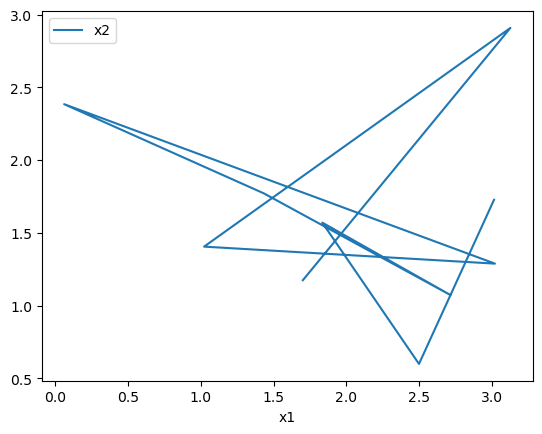

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

/usr/share/miniconda/envs/xopt-dev/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136119739/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


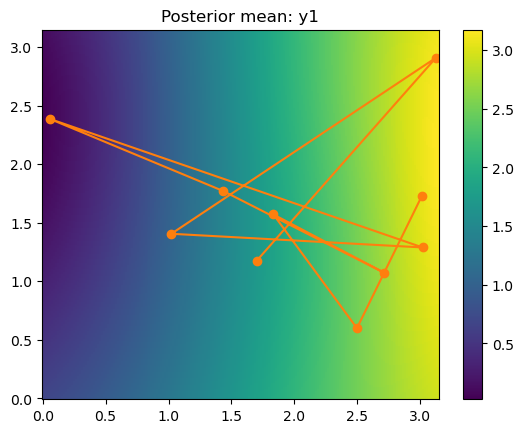

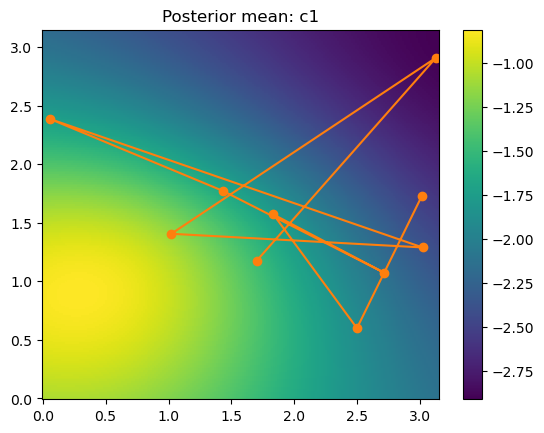

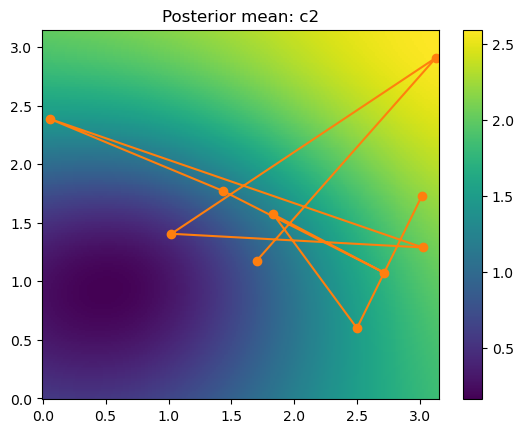

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "o-C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n))
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

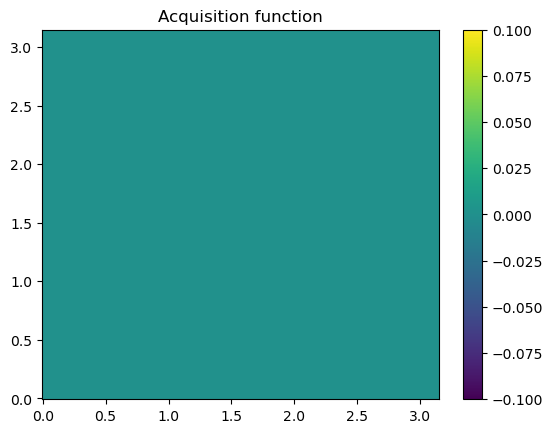

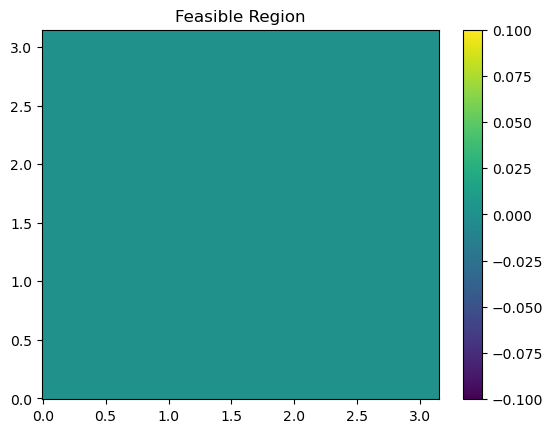

In [7]:
from xopt.generators.bayesian.utils import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.generator.sampler, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")